In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from matplotlib import pyplot as plt 
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import cv2
import csv
import os
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random 
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
import pickle
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import time
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage
from skimage.transform import resize
import tensorflow as tf
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [4]:
# Dataset Paths
dataset_path = r"/content/gdrive/Shareddrives/Tugas Akhir/Dataset"

json_refuge_path = os.path.join(dataset_path, 'df_refugetrain.json')
json_refugeval_path = os.path.join(dataset_path, 'df_refugeval.json')
json_refugetest_path = os.path.join(dataset_path, 'df_refugetest.json')
json_drishti_path = os.path.join(dataset_path, 'df_drishti.json')

# Load Dataset

In [5]:
df_refugetest = pd.read_json(json_refugetest_path)
df_refugeval = pd.read_json(json_refugeval_path)
df_refuge = pd.read_json(json_refuge_path)
df_drishti= pd.read_json(json_drishti_path)

In [6]:
df = pd.concat([df_drishti, df_refuge, df_refugeval, df_refugetest], ignore_index=True)
df.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge test   Glaucoma     40
              Normal      360
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     40
              Normal      360
dtype: int64

In [7]:
df.head()

,path,file_name,disc_center,tag,dataset,shape,VCDR,HCDR,ACDR,path_OD_png,path_OC_png
0,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishtiGS_002.png,"[992, 840]",Glaucoma,drishti,"[2045, 1752]",0.708978,0.761610,0.553771,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...
1,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishtiGS_004.png,"[988, 1100]",Glaucoma,drishti,"[2049, 1762]",0.811209,0.879056,0.670667,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...
2,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishtiGS_008.png,"[1099, 960]",Normal,drishti,"[2049, 1755]",0.601156,0.598266,0.346092,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...
3,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishtiGS_010.png,"[989, 905]",Glaucoma,drishti,"[2140, 1757]",0.869458,0.928571,0.787130,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...
4,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishtiGS_012.png,"[1085, 1038]",Glaucoma,drishti,"[2047, 1755]",0.827692,0.972308,0.735088,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...


# Explore

In [ ]:
H_OD = np.array([])
H_OC = np.array([])
W_OD = np.array([])
W_OC = np.array([])
for i in range(len(df)):
  OD_mask = cv2.imread(df['path_OD_png'].iloc[i], 0)
  OC_mask = cv2.imread(df['path_OC_png'].iloc[i], 0)
  OD_mask,_ = cv2.findContours(OD_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OC_mask,_ = cv2.findContours(OC_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  OD_mask = cv2.approxPolyDP(OD_mask[0], 3, True)
  OC_mask = cv2.approxPolyDP(OC_mask[0], 3, True)
  _, _, w_OD, h_OD = cv2.boundingRect(OD_mask)
  _, _, w_OC, h_OC = cv2.boundingRect(OC_mask)
  height = df['shape'].iloc[i][1]
  width = df['shape'].iloc[i][0]
  H_OD = np.append(H_OD, h_OD/height)
  H_OC = np.append(H_OC, h_OC/height)
  W_OD = np.append(W_OD, w_OD/width)
  W_OC = np.append(W_OC, w_OC/width)

KeyboardInterrupt: ignored

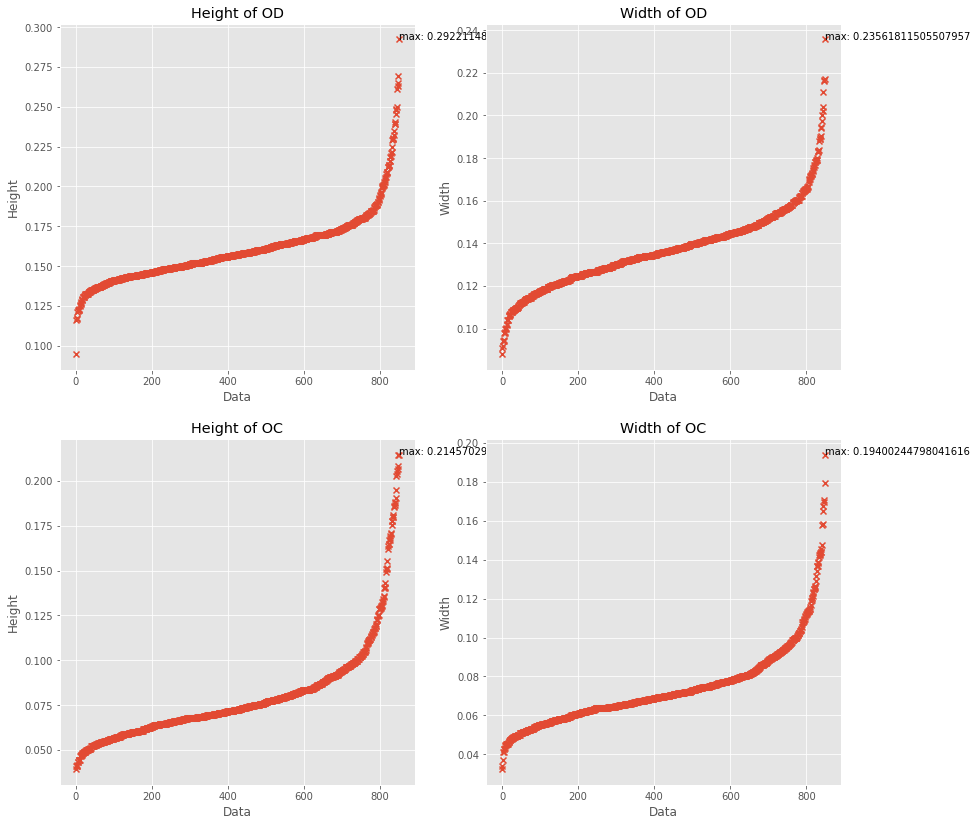

In [ ]:
H_OD_sorted = np.sort(H_OD, axis=0)
H_OC_sorted = np.sort(H_OC, axis=0)
W_OD_sorted = np.sort(W_OD, axis=0)
W_OC_sorted = np.sort(W_OC, axis=0)
plt.figure(figsize=(14,14))
plt.subplot(221), 
plt.scatter(list(range(len(df))), H_OD_sorted, marker='x')
plt.title('Height of OD')
plt.text(np.argmax(H_OD_sorted), np.max(H_OD_sorted), 'max: {}'.format(np.max(H_OD)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(223),
plt.scatter(list(range(len(df))), H_OC_sorted, marker='x')
plt.title('Height of OC')
plt.text(np.argmax(H_OC_sorted), np.max(H_OC_sorted), 'max: {}'.format(np.max(H_OC)))
plt.xlabel('Data')
plt.ylabel('Height')
plt.subplot(222),
plt.scatter(list(range(len(df))), W_OD_sorted, marker='x')
plt.title('Width of OD')
plt.text(np.argmax(W_OD_sorted), np.max(W_OD_sorted), 'max: {}'.format(np.max(W_OD)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.subplot(224),
plt.scatter(list(range(len(df))), W_OC_sorted, marker='x')
plt.title('Width of OC')
plt.text(np.argmax(W_OC_sorted), np.max(W_OC_sorted), 'max: {}'.format(np.max(W_OC)))
plt.xlabel('Data')
plt.ylabel('Width')
plt.show()

# Fungsi Lokalisasi

In [ ]:
def extract_BR_map(src, mask, numSegments=50, sigma=10):
  """
    This is the function of brightness map of retinal images extraction. 
    Brightness map is an image that contain well-segmented areas of retinal images
    that filled with the brightness of those areas. This maps give the brightness
    information of all area in retinal image. Since the Optic Disc typically
    the one of brightest area in retinal images, this map helps identify the
    location of Optic Disc.
    
    Input:
    src: retinal images (RGB)
    mask: mask for Masking out non-retinal area of the image
    numSegments: The number of segment in the brightness map
    sigma: the size of gaussian filter for blurring the image

    Output:
    Brightnes map: the combined brightness across R, G, B channels
  """

  #Resize imagen source
  H, W = src.shape[:2]
  
  # Resizing the image to quarter size for accelerating the computation
  resized_src = resize(src, output_shape=(H//4, W//4), mode = 'constant')
  resized_mask =  resize(mask, output_shape=(H//4, W//4), mode = 'constant')

  # Blurring the image tim improve the segment accuracy
  blur = cv2.GaussianBlur(resized_src, (37, 37), 0)

  # Segmenting the retinal image using SLIC algorithm 
  segments = slic(blur, n_segments=numSegments, sigma=sigma, mask=resized_mask)
  # boundary = mark_boundaries(resized_src, segments)

  labels = np.unique(segments)
  h, w = resized_src.shape[:2]

  # initiate the brightness map of R, G, and B channel
  g_map = np.zeros([h, w], np.float32)
  r_map = np.zeros([h, w], np.float32)
  b_map = np.zeros([h, w], np.float32)


  r_src = resized_src[:, :, 0]
  g_src = resized_src[:, :, 1]
  b_src = resized_src[:, :, 2]

  # Filling the segment with brightness of it
  for label in labels:
    # Brightness is define as the maximum intensity of each segment
    r_map[segments==label] = np.max(r_src[segments==label])
    g_map[segments==label] = np.max(g_src[segments==label])
    b_map[segments==label] = np.max(b_src[segments==label])

  # Resize back the brightness map to its original size
  r_resized_map = resize(r_map, output_shape=(H, W), mode='constant', preserve_range=True)
  g_resized_map = resize(g_map, output_shape=(H, W), mode='constant', preserve_range=True)
  b_resized_map = resize(b_map, output_shape=(H, W), mode='constant', preserve_range=True)

  # combining brightness map using average method
  combined_brightness_map = (r_resized_map + g_resized_map + b_resized_map)/3
  
  return combined_brightness_map

def padding(NCC, h, w):
  """
    This function will zero padding the NCC map such that NCC map have the same size
    with retinal images
  """

  ver = (h - NCC.shape[0])/2
  hor = (w - NCC.shape[1])/2
  top = math.floor(ver)
  bottom = math.ceil(ver)
  left =  math.floor(hor)
  right = math.ceil(hor)
  value = 0
  borderType = cv2.BORDER_CONSTANT
  zeropadded_NCC = cv2.copyMakeBorder(NCC, top, bottom, left, right, borderType, value)
  return zeropadded_NCC

def image_template_matching(clahe_retinal_img, template, mask):
  """
    This is a function for OD template matching. This will yields Normalized
    Correlation Coefficient (NCC) of R, G, and B channel. 

    Input:
    clahe_retinal_img: RGB retinal image that had been CLAHE-ed
    template: OD template image 
    mask: Mask for masking out the non-retinal area

    Output: 
    NCC_maps: NCC image of R, G, and B channel
  """

  h, w = clahe_retinal_img[0].shape[:2]
  NCC_maps = []
  for i, clahe_image in enumerate(clahe_retinal_img):
    # checking clahe image isn't zeros 
    if len(np.unique(clahe_image)) > 0: 
      NCC = cv2.matchTemplate(clahe_image, template[i], cv2.TM_CCOEFF_NORMED)
      NCC = NCC + abs(np.min(NCC))
      NCC = padding(NCC, h, w)
      NCC = NCC * mask

    NCC_maps.append(NCC)
  
  return NCC_maps

In [ ]:
def OD_Localization(src, template_images, used_channels='rgb',
                  bright_on=True, test_on=False, 
                  r_coeff=1, g_coeff=1, b_coeff=1, br_coeff=1):
  """
    This is the main function for localization of Optic Disc
    
    Input:
    src: retinal images (RGB)
    template_images: Optic Disc template images of R, G, B channles
    used_channels: defining the used NCC channels for localization
    NCC_on : Use NCC map for localization
    bright_on : Use brightness map for localization
    r_coeff: coefficient of red_NCC map 
    g_coeff: coefficient of green_NCC map 
    b_coeff: coefficient of blue_NCC map 
    br_coeff: coefficient of brightness map 

    Output:
    disk_center: Optic Disc Center
    all_maps: list of created maps for localization, returned only if 
    test_on is True.
  """

    
  h, w = src.shape[:2]

  # Implement CLAHE to the input image 
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(src[:, :, 1])
  
  zeros = np.zeros([h, w], np.uint8)
  img = [zeros, zeros, zeros]
  
  # Apply CLAHE to each of image channel 
  for channel in used_channels:
    if channel == 'r':
      img[0] = clahe.apply(src[:, :, 0])
    elif channel == 'g':
      img[1] = clahe.apply(src[:, :, 1])
    elif channel == 'b':
      image = clahe.apply(src[:, :, 2])
      img[2] = image
    
  # Mask Out outside retinal image
  blurred = cv2.GaussianBlur(cl_img, (7, 7), 0)
  (T, mask) = cv2.threshold(blurred, 10 , 255, cv2.THRESH_BINARY)
  mask = mask/255

  # Extract the NCC maps
  red_NCC, green_NCC, blue_NCC = image_template_matching(img, template_images, mask)

  # Extract superpixel map
  if bright_on:
    brightness_map = extract_BR_map(src, mask)
  else:
    brightness_map = zeros

  # Combining localization maps 
  combined_map = red_NCC * r_coeff + green_NCC*g_coeff + blue_NCC*b_coeff + brightness_map*br_coeff
  all_maps = [combined_map, red_NCC, green_NCC, blue_NCC, brightness_map]
  
  # Extracting maximum value of NCC
  y, x = list(zip(*np.where(combined_map==np.max(combined_map))))[0]
  disk_center = (x, y)

  # Return all maps for testing the algorithm only
  if test_on:
    return disk_center, all_maps 
  elif not test_on:
    return disk_center

In [ ]:
def checkROI(OD, center, shape):
  mvoulana = 0
  zheng = 0
  luasgtAsli = np.sum(OD==255)
  ROI, _ = ekstrakROI(center, 0.2*shape[0], OD)
  luasgtROI = np.sum(ROI==255)
  presentasi = (luasgtROI/ luasgtAsli) * 100
  coordinates = np.where(OD==255)
  coordinates = list(zip(*coordinates))
  center_temp = (center[1], center[0])

  # kriteria mvoulana
  if center_temp in coordinates:
    mvoulana = 1
  if presentasi == 100:
    zheng = 1
  return presentasi, mvoulana, zheng

In [ ]:
def MeanProportion(Proportion):
  mean = np.mean(Proportion)
  std = np.std(Proportion)
  print('Proporsi ROI pada OD: {:.3f} +- {:.3f}'.format(mean, std))

In [ ]:
def ekstrakROI(centroid, s, img):

  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = math.floor(x - 0.5*s)
  x1 = math.floor(x + 0.5*s)
  y0 = math.floor(y - 0.5*s)
  y1 = math.floor(y + 0.5*s)

  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0

  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0

  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)

  return y0, y1, x0, x1

# Lokalisasi (Kak Nafis)

In [ ]:
# Templates
image_R = cv2.imread('/content/gdrive/Shareddrives/Tugas Akhir/TA kak Anfis/Kode/Template/ROItemplateRed.png', 0)
image_G = cv2.imread('/content/gdrive/Shareddrives/Tugas Akhir/TA kak Anfis/Kode/Template/ROItemplateGreen.png', 0)
image_B = cv2.imread('/content/gdrive/Shareddrives/Tugas Akhir/TA kak Anfis/Kode/Template/ROItemplateBlue.png', 0)
image_templates = [image_R, image_G, image_B]

In [ ]:
localization = []
percent_detection = []
mvoulana = []
zheng = []

for i in tqdm(range(0, 850)):
  image_path = df["path"].iloc[i] # path image retina yang dituju
  path_OD = df["path_OD_png"].iloc[i]
  shape = df["shape"].iloc[i]
  OD_mask_gt = cv2.imread(path_OD, 0)
  # tunned parameter
  r_coeff, g_coeff,b_coeff, br_coeff = 1, 0.2, 0, 0.8
  used_channels = 'rg'
  src_image = cv2.imread(image_path, 1) # reading image retina
  src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB) # Konversi warna BGR ke RGB
  disk_center, all_maps = OD_Localization(src_image, image_templates,
                                          used_channels=used_channels, 
                                          bright_on=True, 
                                          test_on=True, 
                                          r_coeff=r_coeff, 
                                          g_coeff=g_coeff, 
                                          b_coeff=b_coeff,
                                          br_coeff=br_coeff)
  percentage, m, z = checkROI(OD_mask_gt, disk_center, shape)
  percent_detection.append(percentage)
  mvoulana.append(m)
  zheng.append(z)
  localization.append(disk_center)

  0%|          | 0/850 [00:00<?, ?it/s]

In [ ]:
MeanProportion(percent_detection)
MeanProportion(mvoulana)
MeanProportion(zheng)

Proporsi ROI pada OD: 99.213 +- 5.502
Proporsi ROI pada OD: 0.993 +- 0.084
Proporsi ROI pada OD: 0.906 +- 0.292


In [ ]:
sum(zheng)

770

In [ ]:
df["proportion"] = percent_detection
df["localization"] = localization

In [ ]:
df_drishti = df.loc[(df["dataset"] == "drishti")]
df_refuge = df.loc[(df["dataset"] == "refuge train")]
df_refugeval = df.loc[(df["dataset"] == "refuge val")]
df_refugetest = df.loc[(df["dataset"] == "refuge test")]

MeanProportion(df_drishti["proportion"])
MeanProportion(df_refuge["proportion"])
MeanProportion(df_refugeval["proportion"])
MeanProportion(df_refugetest["proportion"])

Proporsi ROI pada OD: 96.440 +- 5.545
Proporsi ROI pada OD: 99.692 +- 1.559
Proporsi ROI pada OD: 99.082 +- 7.540
Proporsi ROI pada OD: 99.925 +- 0.901


In [ ]:
# Save Dataframe
json_local_path = os.path.join(dataset_path, 'df_local.json')

df.reset_index(inplace=True, drop=True)

if os.path.isfile(json_local_path):
  os.remove(json_local_path)
  df.to_json(json_local_path)
else:
  df.to_json(json_local_path)

# Explore

In [ ]:
json_local_path = os.path.join(dataset_path, 'df_local.json')
df = pd.read_json(json_local_path)

## Failed Localization

In [ ]:
df_pro = df.loc[(df["proportion"] < 100)]
len(df_pro)

2

In [ ]:
df_pro.tail()

,path,file_name,disc_center,tag,dataset,shape,VCDR,HCDR,ACDR,path_OD_png,path_OC_png,proportion,localization
1245,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,T0396.jpg,"[275.3971190797, 796.5225867203]",Normal,refuge test,"[1634, 1634]",0.420290,0.405797,0.153666,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,100.0,"[275, 806]"
1246,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,T0397.jpg,"[574.176679802, 761.1398605638]",Glaucoma,refuge test,"[1634, 1634]",0.750000,0.761905,0.575791,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,100.0,"[579, 771]"
1247,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,T0398.jpg,"[407.7473681501, 797.0865099997]",Normal,refuge test,"[1634, 1634]",0.709845,0.797927,0.432782,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,100.0,"[405, 797]"
1248,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,T0399.jpg,"[493.2450147668, 755.9999084228]",Normal,refuge test,"[1634, 1634]",0.450450,0.545045,0.216878,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,100.0,"[488, 744]"
1249,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,T0400.jpg,"[389.1138474274, 766.5456191634]",Normal,refuge test,"[1634, 1634]",0.471503,0.523316,0.179760,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,100.0,"[426, 775]"


In [ ]:
def local_error(i=0):
    image_path = df_pro["path"].iloc[i] # path image retina yang dituju
    path_OD = df_pro["path_OD_png"].iloc[i]
    OD_mask_gt = cv2.imread(path_OD, 0)
    proportion = df_pro["proportion"].iloc[i]
    # tunned parameter
    r_coeff, g_coeff,b_coeff, br_coeff = 1, 0.2, 0, 0.8
    used_channels = 'rg'
    src_image = cv2.imread(image_path, 1) # reading image retina
    src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB) # Konversi warna BGR ke RGB
    disk_center, all_maps = OD_Localization(src_image, image_templates, 
                                            used_channels=used_channels, 
                                            bright_on=True, 
                                            test_on=True, 
                                            r_coeff=r_coeff, 
                                            g_coeff=g_coeff, 
                                            b_coeff=b_coeff,
                                            br_coeff=br_coeff)
    
    combined_map = all_maps[0] 

    shape = df_pro["shape"].iloc[i]

    

    # Showing disk center location and combined map
    fig, ax = plt.subplots(1, 2, figsize=(7, 14))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    y0, y1, x0, x1 = rectfromcenter(disk_center, 600, shape[1], shape[0])  
    ROI_gt_OD,_ = ekstrakROI(disk_center, 600, OD_mask_gt)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(ROI_gt_OD, cmap='gray')
    ax[1].set_title('ROI: 550 x 550 px')
    

    fig, ax = plt.subplots(1, 2, figsize=(7, 14))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    y0, y1, x0, x1 = rectfromcenter(disk_center, (0.3*shape[0]), shape[1], shape[0])  
    ROI_gt_OD,_ = ekstrakROI(disk_center, (0.3*shape[0]), OD_mask_gt)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(ROI_gt_OD, cmap='gray')
    ax[1].set_title('ROI: 0.3 shape')

    fig, ax = plt.subplots(1, 2, figsize=(7, 14))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    y0, y1, x0, x1 = rectfromcenter(disk_center, (0.4*shape[0]), shape[1], shape[0])  
    ROI_gt_OD,_ = ekstrakROI(disk_center, (0.4*shape[0]), OD_mask_gt)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(ROI_gt_OD, cmap='gray')
    ax[1].set_title('ROI: 0.4 shape')

interact(local_error, i=(0, len(df_pro)-1))

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.local_error>

In [ ]:
def local_error(i=0):
    image_path = df_pro["path"].iloc[i] # path image retina yang dituju
    path_OD = df_pro["path_OD_png"].iloc[i]
    OD_mask_gt = cv2.imread(path_OD, 0)
    proportion = df_pro["proportion"].iloc[i]
    # tunned parameter
    r_coeff, g_coeff,b_coeff, br_coeff = 1, 0.2, 0, 0.8
    used_channels = 'rg'
    src_image = cv2.imread(image_path, 1) # reading image retina
    src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB) # Konversi warna BGR ke RGB
    disk_center, all_maps = OD_Localization(src_image, image_templates, 
                                            used_channels=used_channels, 
                                            bright_on=True, 
                                            test_on=True, 
                                            r_coeff=r_coeff, 
                                            g_coeff=g_coeff, 
                                            b_coeff=b_coeff,
                                            br_coeff=br_coeff)
    
    combined_map = all_maps[0] 

    shape = df_pro["shape"].iloc[i]

    

    # Showing disk center location and combined map
    fig, ax = plt.subplots(1, 4, figsize=(14, 28))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    y0, y1, x0, x1 = rectfromcenter(disk_center, (0.3*shape[0]), shape[1], shape[0])  
    ROI_gt_OD,_ = ekstrakROI(disk_center, (0.3*shape[0]), OD_mask_gt)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(ROI_gt_OD, cmap='gray')
    ax[1].set_title('ROI: 0.3 shape')
    ax[2].imshow(src_image)
    y0, y1, x0, x1 = rectfromcenter(disk_center, (0.4*shape[0]), shape[1], shape[0])  
    ROI_gt_OD,_ = ekstrakROI(disk_center, (0.4*shape[0]), OD_mask_gt)
    ax[2].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[2].add_patch(rect)
    ax[2].set_title('Center of Optic Disc')
    ax[3].imshow(ROI_gt_OD, cmap='gray')
    ax[3].set_title('ROI: 0.4 shape')

    fig, ax = plt.subplots(1, 4, figsize=(14, 28))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(all_maps[1], cmap='gray')
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[0].set_title('Red NCC Map')
    ax[1].imshow(all_maps[2], cmap='gray')
    ax[1].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[1].set_title('Green NCC Map')
    ax[2].imshow(all_maps[4], cmap='gray')
    ax[2].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[2].set_title('Brightness Map')
    ax[3].imshow(all_maps[0], cmap='gray')
    ax[3].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[3].set_title('Combined Map')
    print(df_pro["file_name"].iloc[i])
    print(proportion)

interact(local_error, i=(0, len(df_pro)-1))

interactive(children=(IntSlider(value=0, description='i', max=1247), Output()), _dom_classes=('widget-interact…

<function __main__.local_error>

## Characteristics Old

In [ ]:
df_exp = df.loc[(df["proportion"]>98)]
df_exp = df_exp.iloc[:848]
df_exp.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     38
              Normal      360
dtype: int64

In [ ]:
Dx = np.array([])
Dy = np.array([])
dx = np.array([])
dy = np.array([])
H_OD = np.array([])
W_OD = np.array([])
h_OD = np.array([])
w_OD = np.array([])

for i in range(len(df_exp)):
  center_gt = df_exp["disc_center"].iloc[i]
  loc = df_exp["localization"].iloc[i]
  shape = df_exp["shape"].iloc[i]

  Dx = np.append(Dx, abs(center_gt[0] - loc[0]))
  dx = np.append(dx, abs((center_gt[0] - loc[0])/shape[0]))

  Dy = np.append(Dy, abs(center_gt[1] - loc[1]))
  dy = np.append(dy, abs((center_gt[1] - loc[1])/shape[1]))
  
  path_OD = df_exp["path_OD_png"].iloc[i]
  OD_mask_gt = cv2.imread(path_OD, 0)
  _, _, w, h = cv2.boundingRect(OD_mask_gt)
  H_OD = np.append(H_OD, h)
  W_OD = np.append(W_OD, w)
  h_OD = np.append(h_OD, h/shape[1])
  w_OD = np.append(w_OD, w/shape[0])

In [ ]:
df_exp["Dx"] = Dx
df_exp["Dy"] = Dy
df_exp["dx"] = dx
df_exp["dy"] = dy
df_exp["H_OD"] = H_OD
df_exp["W_OD"] = W_OD
df_exp["h_OD"] = h_OD
df_exp["w_OD"] = w_OD

No handles with labels found to put in legend.


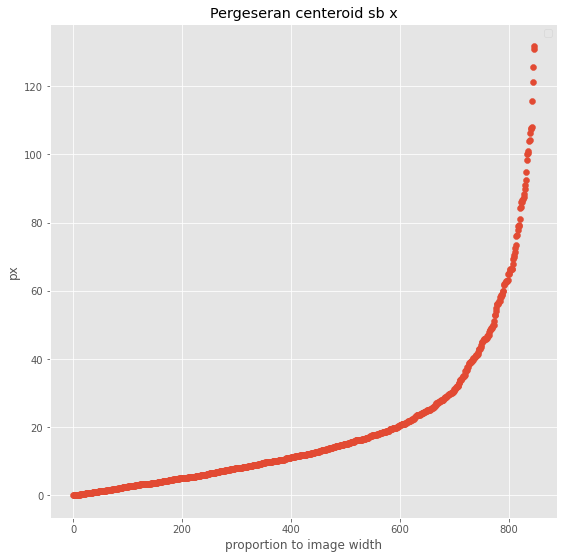

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221), 
df_exp1 = df_exp.sort_values(by=['Dx'])
for g in np.unique(df_exp1["dataset"]):
    i = np.where(df_exp1["dataset"] == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g)

plt.title('Pergeseran centeroid sb x')
# plt.text(np.argmax(Dx), np.max(Dx), 'max: {}'.format(np.max(Dx)))
plt.xlabel('proportion to image width')
plt.ylabel('px')
plt.legend()

# plt.subplot(222),
# plt.scatter(list(range(len(Dy))), Dy, marker='x')
# plt.title('Pergeseran centeroid sb y')
# plt.text(np.argmax(Dy), np.max(Dy), 'max: {}'.format(np.max(Dy)))
# plt.xlabel('Data')
# plt.ylabel('px')
# plt.subplot(223),
# plt.scatter(list(range(len(dx))), dx, marker='x')
# plt.title('Pergeseran mutlak centeroid sb x')
# plt.text(np.argmax(dx), np.max(dx), 'max: {}'.format(np.max(dx)))
# plt.xlabel('Data')
# plt.ylabel('dx/width')
# plt.subplot(224),
# plt.scatter(list(range(len(dy))), dy, marker='x')
# plt.title('Pergeseran mutlak centeroid sb y')
# plt.text(np.argmax(dy), np.max(dy), 'max: {}'.format(np.max(dy)))
# plt.xlabel('Data')
# plt.ylabel('dy/height')
# plt.show()

In [ ]:
df_dx = df_exp.apply(lambda x : True
            if x['Dx'] >= 0 else False, axis = 1)
  
print("Dx positive = ", len(df_exp[df_dx == True].index))
print("Dx negative = ", len(df_exp[df_dx == False].index))

df_dy = df_exp.apply(lambda x : True
            if x['Dy'] >= 0 else False, axis = 1)

print("dy positive = ", len(df_exp[df_dy == True].index))
print("dy negative = ", len(df_exp[df_dy == False].index))

NameError: ignored

In [ ]:
h_OD = []
w_OD = []
for i in range(len(df_exp)):
  disk_center = df_exp["localization"].iloc[i]
  path_OD = df_exp["path_OD_png"].iloc[i]
  OD_mask_gt = cv2.imread(path_OD, 0)
  ROI_gt_OD,_ = ekstrakROI(disk_center, (0.3*shape[0]), OD_mask_gt)
  _, _, w, h = cv2.boundingRect(ROI_gt_OD)
  h_OD.append(h)
  w_OD.append(w)

In [ ]:
df_exp["H OD"] = h_OD
df_exp["W OD"] = w_OD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def try_localization(i=148):
    image_path = df["path"].iloc[i] # path image retina yang dituju
    path_OD = df["path_OD_png"].iloc[i]
    OD_mask_gt = cv2.imread(path_OD, 0)
    
    # tunned parameter
    r_coeff, g_coeff,b_coeff, br_coeff = 1, 0.2, 0, 0.8
    used_channels = 'rg'
    src_image = cv2.imread(image_path, 1) # reading image retina
    src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB) # Konversi warna BGR ke RGB
    disk_center, all_maps = OD_Localization(src_image, image_templates, 
                                            used_channels=used_channels, 
                                            bright_on=True, 
                                            test_on=True, 
                                            r_coeff=r_coeff, 
                                            g_coeff=g_coeff, 
                                            b_coeff=b_coeff,
                                            br_coeff=br_coeff)
    
    combined_map = all_maps[0]

    shape = df["shape"].iloc[i]

    y0, y1, x0, x1 = rectfromcenter(disk_center, (0.3*shape[0]), shape[1], shape[0])
    
    ROI_gt_OD,_ = ekstrakROI(disk_center, (0.3*shape[0]), OD_mask_gt)

    percentage, _, _ = checkROI(OD_mask_gt, disk_center, shape)

    # Showing disk center location and combined map
    fig, ax = plt.subplots(1, 3, figsize=(14, 28))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor='g', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(combined_map, cmap='gray')
    ax[1].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[1].set_title('Combined Map')
    ax[2].imshow(ROI_gt_OD, cmap='gray')
    
    plt.show()
    print("propostion = ", percentage)
    print("File name  = ", df["file_name"].iloc[i])

interact(try_localization, i=(0, len(df)-1))

interactive(children=(IntSlider(value=148, description='i', max=849), Output()), _dom_classes=('widget-interac…

<function __main__.try_localization>

In [ ]:
df

,path,file_name,disc_center,tag,dataset,shape,VCDR,HCDR,ACDR,path_OD_png,path_OC_png,proportion,localization
0,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,V0001.jpg,"[432.6411386905, 822.152913496]",Normal,refuge test,"[1634, 1634]",0.538136,0.500000,0.256990,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,100.000000,"[425, 818]"
1,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,V0002.jpg,"[447.436329961, 767.2766071855]",Normal,refuge test,"[1634, 1634]",0.441176,0.495798,0.191707,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,100.000000,"[489, 785]"
2,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,V0003.jpg,"[307.7551281395, 813.8344842873]",Normal,refuge test,"[1634, 1634]",0.466667,0.503704,0.232527,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,100.000000,"[323, 812]"
3,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,V0004.jpg,"[450.2496211599, 815.381044221]",Normal,refuge test,"[1634, 1634]",0.426966,0.449438,0.133572,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,100.000000,"[474, 822]"
4,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,V0005.jpg,"[429.3118498021, 845.6667483975]",Normal,refuge test,"[1634, 1634]",0.462500,0.500000,0.164699,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,/content/gdrive/My Drive/Tugas Akhir/Dataset/R...,100.000000,"[457, 838]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,drishtiGS_090.png,"[1081, 962]",Normal,drishti,"[2049, 1749]",0.485876,0.497175,0.228233,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,100.000000,"[1024, 957]"
846,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,drishtiGS_092.png,"[906, 1055]",Normal,drishti,"[2050, 1749]",0.526912,0.549575,0.273871,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,100.000000,"[892, 1068]"
847,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,drishtiGS_094.png,"[957, 1006]",Normal,drishti,"[2049, 1750]",0.538462,0.551282,0.260691,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,100.000000,"[947, 1030]"
848,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,drishtiGS_098.png,"[835, 983]",Normal,drishti,"[2048, 1749]",0.614634,0.646341,0.393113,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,/content/gdrive/My Drive/Tugas Akhir/Dataset/D...,99.198106,"[754, 964]"


# Data Semantics

In [ ]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

In [ ]:
path_semantic = os.path.join(dataset_path, "Data Semantic")
semantic_OD = []
semantic_OC = []
semantic_img = []

if not os.path.isdir(path_semantic):
  os.mkdir(path_semantic)

if not os.path.isdir(os.path.join(path_semantic, "drishti")):
  os.mkdir(os.path.join(path_semantic, "drishti"))

if not os.path.isdir(os.path.join(path_semantic, "refuge")):
  os.mkdir(os.path.join(path_semantic, "refuge"))

if not os.path.isdir(os.path.join(path_semantic, "refuge val")):
  os.mkdir(os.path.join(path_semantic, "refuge val"))

if not os.path.isdir(os.path.join(path_semantic, "refuge test")):
  os.mkdir(os.path.join(path_semantic, "refuge test"))

if not os.path.isdir(os.path.join(path_semantic, "drishti", "image")):
  os.mkdir(os.path.join(path_semantic, "drishti", "image"))

if not os.path.isdir(os.path.join(path_semantic, "drishti", "gt")):
  os.mkdir(os.path.join(path_semantic, "drishti", "gt"))

if not os.path.isdir(os.path.join(path_semantic, "refuge", "image")):
  os.mkdir(os.path.join(path_semantic, "refuge", "image"))

if not os.path.isdir(os.path.join(path_semantic, "refuge", "gt")):
  os.mkdir(os.path.join(path_semantic, "refuge", "gt"))

if not os.path.isdir(os.path.join(path_semantic, "refuge test", "image")):
  os.mkdir(os.path.join(path_semantic, "refuge test", "image"))

if not os.path.isdir(os.path.join(path_semantic, "refuge test", "gt")):
  os.mkdir(os.path.join(path_semantic, "refuge test", "gt"))

if not os.path.isdir(os.path.join(path_semantic, "refuge val", "image")):
  os.mkdir(os.path.join(path_semantic, "refuge val", "image"))

if not os.path.isdir(os.path.join(path_semantic, "refuge val", "gt")):
  os.mkdir(os.path.join(path_semantic, "refuge val", "gt"))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i in tqdm(range(0, len(df))):  
  center = df['localization'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)
  shape = df['shape'][i]
  img,_ = ekstrakROI(center, (0.3*shape[0]), img)
  gt_OD,_ = ekstrakROI(center, (0.3*shape[0]), gt_OD)
  gt_OC,_ = ekstrakROI(center, (0.3*shape[0]), gt_OC)

  img = resize(img, (550, 550, 1), mode = 'constant', preserve_range = True)
  gt_OD = resize(gt_OD, (550, 550, 1), mode = 'constant', preserve_range = True)
  gt_OC = resize(gt_OC, (550, 550, 1), mode = 'constant', preserve_range = True)
  
  name = os.path.splitext(df['file_name'][i])[0]

  if df['dataset'][i] == 'drishti':
    semantic_img.append(os.path.join(path_semantic, 'drishti', 'image', 'localized_image_{}.png'.format(name)))   
    semantic_OD.append(os.path.join(path_semantic, 'drishti', 'gt', 'localized_gtOD_{}.png'.format(name)))
    semantic_OC.append(os.path.join(path_semantic, 'drishti', 'gt', 'localized_gtOC_{}.png'.format(name)))
  elif df['dataset'][i] == 'refuge train':
    semantic_img.append(os.path.join(path_semantic, 'refuge', 'image', 'localized_image_{}.png'.format(name)))
    semantic_OD.append(os.path.join(path_semantic, 'refuge', 'gt', 'localized_gtOD_{}.png'.format(name)))
    semantic_OC.append(os.path.join(path_semantic, 'refuge', 'gt', 'localized_gtOC_{}.png'.format(name)))
  elif df['dataset'][i] == 'refuge val':
    semantic_img.append(os.path.join(path_semantic, 'refuge val', 'image', 'localized_image_{}.png'.format(name)))
    semantic_OD.append(os.path.join(path_semantic, 'refuge val', 'gt', 'localized_gtOD_{}.png'.format(name)))
    semantic_OC.append(os.path.join(path_semantic, 'refuge val', 'gt', 'localized_gtOC_{}.png'.format(name)))
  elif df['dataset'][i] == 'refuge test':
    semantic_img.append(os.path.join(path_semantic, 'refuge test', 'image', 'localized_image_{}.png'.format(name)))
    semantic_OD.append(os.path.join(path_semantic, 'refuge test', 'gt', 'localized_gtOD_{}.png'.format(name)))
    semantic_OC.append(os.path.join(path_semantic, 'refuge test', 'gt', 'localized_gtOC_{}.png'.format(name)))
  
  saving_image(img, semantic_img[-1])    
  saving_image(gt_OD, semantic_OD[-1])
  saving_image(gt_OC, semantic_OC[-1])

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
df["path_OD_loc"] = semantic_OD
df["path_OC_loc"] = semantic_OC
df["path_img_loc"] = semantic_img

In [ ]:
json_local_path = os.path.join(dataset_path, 'df_local_crop.json')

if os.path.isfile(json_local_path):
  os.remove(json_local_path)
  df.to_json(json_local_path)
else:
  df.to_json(json_local_path)

# Proportion

In [ ]:
df_drishti = df.loc[(df["dataset"] == "drishti")]
df_refuge = df.loc[(df["dataset"] == "refuge train")]
df_refugetest = df.loc[(df["dataset"] == "refuge test") & (df["proportion"] > 98)]
df_refugetest = df_refugetest.reset_index()

print(len(df_drishti))
print(len(df_refuge))
print(len(df_refugetest))

50
400
398


In [ ]:
H_drishti = np.array([])
W_drishti = np.array([])
H_refuge = np.array([])
W_refuge = np.array([])
H_refugetest = np.array([])
W_refugetest = np.array([])

for i in tqdm(range(0, len(df))):
  if df["proportion"].iloc[i] > 98:
    OD_mask = cv2.imread(df['path_OD_png'].iloc[i], 0)
    OC_mask = cv2.imread(df['path_OC_png'].iloc[i], 0)
    shape = df['shape'].iloc[i]
    OD_mask,_ = cv2.findContours(OD_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    OC_mask,_ = cv2.findContours(OC_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    OD_mask = cv2.approxPolyDP(OD_mask[0], 3, True)
    OC_mask = cv2.approxPolyDP(OC_mask[0], 3, True)
    _, _, w_OD, h_OD = cv2.boundingRect(OD_mask)
    _, _, w_OC, h_OC = cv2.boundingRect(OC_mask)

    if df['dataset'].iloc[i] == 'drishti':
      H_drishti = np.append(H_drishti, h_OD/550)
      W_drishti = np.append(W_drishti, w_OD/550)
  
    elif df['dataset'].iloc[i] == 'refuge train':
      H_refuge = np.append(H_refuge, h_OD/550)
      W_refuge = np.append(W_refuge, w_OD/550)

    elif df['dataset'].iloc[i] == 'refuge test':
      H_refugetest = np.append(H_refugetest, h_OD/(0.25 * shape[0]))
      W_refugetest = np.append(W_refugetest, w_OD/(0.25 * shape[0]))

  0%|          | 0/850 [00:00<?, ?it/s]

In [ ]:
df_drishti['H_OD'] = H_drishti.tolist()
df_drishti['W_OD'] = W_drishti.tolist()

df_refuge['H_OD'] = H_refuge.tolist()
df_refuge['W_OD'] = W_refuge.tolist()

df_refugetest['H_OD'] = H_refugetest.tolist()
df_refugetest['W_OD'] = W_refugetest.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
H_drishti = np.sort(H_drishti, axis=0)
W_drishti = np.sort(W_drishti, axis=0)
H_refuge = np.sort(H_refuge, axis=0)
W_refuge = np.sort(W_refuge, axis=0)
H_refugetest = np.sort(H_refugetest, axis=0)
W_refugetest = np.sort(W_refugetest, axis=0)

H = np.concatenate((H_drishti, H_refuge, H_refugetest), axis=None)
H_order = H.argsort()
H_ranks = H_order.argsort()

W = np.concatenate((W_drishti, W_refuge, W_refugetest), axis=None)
W_order = W.argsort()
W_ranks = W_order.argsort()

In [ ]:
H_drishti_ranks = H_ranks[:50]
W_drishti_ranks = W_ranks[:50]
H_refuge_ranks = H_ranks[50:450]
W_refuge_ranks = W_ranks[50:450]
H_refugetest_ranks = H_ranks[450:]
W_refugetest_ranks = W_ranks[450:]

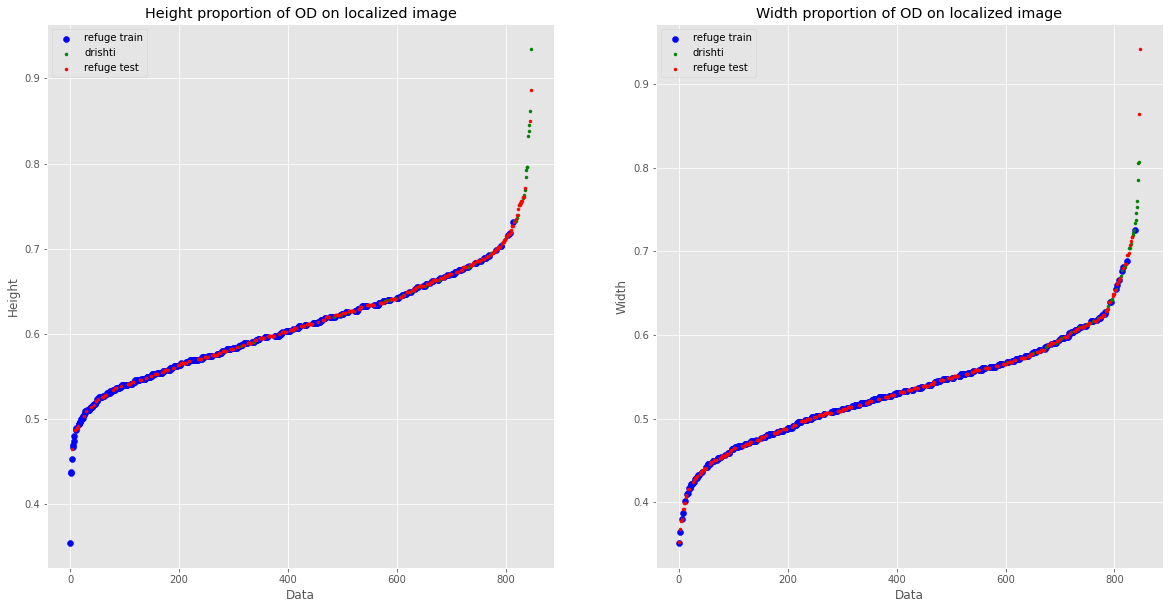

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121), 
plt.scatter(H_refuge_ranks, H_refuge, marker='o', c = 'blue', label = 'refuge train')
plt.scatter(H_drishti_ranks, H_drishti, marker='.', c = 'green', label = 'drishti')
plt.scatter(H_refugetest_ranks, H_refugetest, marker='.', c = 'red', label = 'refuge test')
plt.title('Height proportion of OD on localized image')
plt.xlabel('Data')
plt.ylabel('Height')
plt.legend()
plt.subplot(122),
plt.scatter(W_refuge_ranks, W_refuge, marker='o', c = 'blue', label = 'refuge train')
plt.scatter(W_drishti_ranks, W_drishti, marker='.', c = 'green', label = 'drishti')
plt.scatter(W_refugetest_ranks, W_refugetest, marker='.', c = 'red', label = 'refuge test')
plt.title('Width proportion of OD on localized image')
plt.xlabel('Data')
plt.ylabel('Width')
plt.legend()